<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: Юрий Исаков

# <center> Домашнее задание № 4. Часть 1
## <center>  Идентификация пользователя с помощью логистической регрессии

В этой домашней работе мы научимся работать с разреженными матрицами, обучать логистическую регрессию, формировать и отбирать признаки, а также воспроизведем два бейслайна учебного [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking) "Catch Me If You Can: Intruder Detection through Webpage Session Tracking" на Kaggle Inclass. В этой домашней работе 9 заданий, которые вам предстоит выполнить и после этого заполнить ответы в [гугл-форме](https://docs.google.com/forms/d/e/1FAIpQLSd8E7naU38ikc9-rd31KeVfez3emCo4Ok1WrpQTr-XCDelRiw/viewform).

In [1]:
# загрузим библиотеки и установим опции

from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

##### О соревновании
Мы будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера: компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой). В качестве метрики в этом соревновании используется [ROC AUC](https://ru.wikipedia.org/wiki/ROC-кривая). Кто такая Элис, мы расскажем в конце курса.

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки, посмотрим на данные и выполним несколько простых заданий:

In [2]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/websites_train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/websites_test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, принимает значение 1 для сессий Элис и 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или содержит более 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулем и приведем колонки целому типу. Также загрузим словарь сайтов и посмотрим как он выглядит:

In [3]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'всего сайтов:', sites_dict.shape[0])
sites_dict.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu



#### Задание 1: Какие размерности имеют тестовая и обучающая выборки?

- (82797, 20) (253561, 20)
- (82797, 20) (253561, 21)
- (253561, 21) (82797, 20)
- (253561, 20) (82797, 20)

In [4]:
print(train_df.shape)
print(test_df.shape)

(253561, 21)
(82797, 20)


In [5]:
set(train_df.columns) - set(test_df.columns)

{'target'}

### 2. Очень краткий первичный анализ

Перед тем, как начинать строить модели, необходимо провести первичный (разведочный) анализ ([EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis)). Мы сделаем его краткую версию, но по мере продвижения начнём пользоваться другими его техниками. Посмотрим, какие сайты из обучающей выборки наиболее посещаемые. Ими оказались сервисы компании Гугл и сайт по биоинформатике (сайт с "нулевым" индексом — это наши пропущенные значения, просто проигнорируем его):

In [7]:
# топ-сайты в обучающей выборке
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.ix[top_sites.index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
0,NaN
23,www.google.com
782,annotathon.org
22,apis.google.com


##### Задание 2: Какие сайты Элис посещает в сети наиболее часто?

- видеохостинги
- социальные сети
- торрент-трекеры
- новостные сайты

In [57]:
alice_top_sites = pd.Series(
    train_df[train_df["target"] == 1][sites].fillna(0).values.flatten()
).value_counts().sort_values(ascending=False).head(5)
print(alice_top_sites)
sites_dict.ix[alice_top_sites.index]

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


Теперь посмотрим на временные отметки и попробуем охарактеризовать сессии временными интервалами:

In [9]:
# создадим отдельный датафрейм, где будем работать со временем
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# найдем время начала и окончания сессии
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# вычислим длительность сессии и переведем в секунды
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


Чтобы выполнить следующее задание, составьте описательные статистики по образу тех, которые вы делали в домашней работе на первой неделе. 

##### Задание 3. Выберите все верные утверждения (может оказаться один верный ответ, несколько или ни одного):

- в среднем сессия Элис короче, чем у остальных пользователей
- доля сессий Элис в выборке больше 1%
- диапазоны длительности сессий и Элис, и остальных примерно одинаковы
- разброс значений относительно среднего у всех пользователей (Элис в том числе) приблизительно одинаков
- доля сессий Элис от 40 секунд и дольше составляет менее четверти

In [11]:
print(time_df[time_df["target"] == 1].seconds.mean())
print(time_df[time_df["target"] == 0].seconds.mean())

52.29647366129734
139.28237232552215


In [21]:
time_df["target"].mean()

0.00905896411514389

In [22]:
print("%.1f - %.1f" % (time_df[time_df["target"] == 1].seconds.min(), time_df[time_df["target"] == 1].seconds.max()))
print("%.1f - %.1f" % (time_df[time_df["target"] == 0].seconds.min(), time_df[time_df["target"] == 0].seconds.max()))

0.0 - 1763.0
0.0 - 1800.0


In [24]:
print(time_df[time_df["target"] == 1].seconds.std())
print(time_df[time_df["target"] == 0].seconds.std())

153.30901405274335
296.65351771850226


In [29]:
print(
    len(time_df[(time_df["target"] == 1) & (time_df["seconds"] >= 40)])
    / len(time_df[(time_df["target"] == 1)])
)

0.2411841532433609


Чтобы обучить нашу первую модель, необходимо подготовить данные. С самого начала выделим целевую переменную и удалим ее из обучающей выборки. Теперь и обучающая, и тестовая выборки будут иметь одинаковое количество колонок, поэтому объединим их в один общий датафрейм. Таким образом, все преобразования будут выполняться одновременно как для обучающей, так и для тестовой выборок. С одной стороны, это ведет к тому, что у обеих выборок будет одно пространство признаков (можно не волноваться, что забыли сделать преобразование какого-то признака для одной из выборок), но с другой возрастает время обработки. Для больших выборок может оказаться невозможным сделать преобразования одновременно для обеих выборок (а иногда преобразования придется разбивать на несколько этапов только для обучающей/тестовой выборки). Здесь же мы будем делать преобразования для объединенной таблицы целиком, а перед обучением или прогнозированием просто возьмем нужную ее часть.

In [30]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

Для самой первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). За таким выбором данных для модели стоит следующая идея:  *у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис, и наоборот.*

Подготовим данные, из всей таблицы выберем только признаки `site1, site2, ... , site10`. Напомним, что пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:

In [31]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Сессии представляют собой последовательность индексов сайтов, и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. Это делается в две строчки:

In [32]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

Если вы поняли, что здесь произошло, то можете пропустить следующий кусок (может, и с логистической регрессией тоже умеете обращаться?), если нет, то давайте разберемся.

### Лирическое отступление 1: разреженные матрицы

Оценим, сколько потребуется памяти для хранения наших данных на примере преобразований выше. Наша объединенная таблица содержит 336 тысяч наблюдений по 48 тысяч целочисленных признаков в каждом. Нетрудно посчитать необходимый объем памяти, навскидку это: $$336K * 48K * 8 байт = 16M * 8 байт = 128 Гбайт,$$ (а вот [точное](http://www.wolframalpha.com/input/?i=336358*48371*8+bytes) значение). Очевидно, что таких объемов у простых смертных нет (вообще говоря, Питон может и позволить вам создать такую матрицу, но вот уже что-то сделать с ней будет непросто). Что характерно, большинство элементов нашей матрицы — нули. Если мы посчитаем ненулевые элементы, то их окажется порядка 1.8 млн., т.е. чуть больше 10% от всех элементов матрицы. Такая матрица, где большинство элементов нулевые, называется разреженной, а отношение количества нулевых элементов к общему числу элементов называется разреженностью матрицы.

Для работы с такими данными можно использовать библиотеку `scipy.sparse`, посмотрите [документацию](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html), чтобы разобраться, какие разреженные матрицы бывают, как с ними работать и в каких случаях их использование наиболее эффективно. О том, как они устроены, можно прочитать, например, в [статье](https://en.wikipedia.org/wiki/Sparse_matrix) англоязычной Википедии. Мы же отметим, что разреженная матрица хранит только ненулевые элементы, а место, занимаемое в памяти можно получить вот так (очевидна существенная экономия памяти):

In [35]:
# Сколько места занимает разреженная матрица в памяти?
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# или сразу вот так:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))
print('sparse_matrix_size = {0} MB'.format(full_sites_sparse.data.nbytes / 1024 / 1024))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 14935184 bytes
sparse_matrix_size = 14.243301391601562 MB


Давайте теперь на минипримере разберемся, как была сформирована матрица с сайтами. Предположим, у нас имеется вот такая таблица с сессиями пользователей:

| id | site1 | site2 | site3 |
|---|---|---|---|
| 1 | 1 | 0 | 0 |
| 2 | 1 | 3 | 1 |
| 3 | 2 | 3 | 4 |

Имеется 3 сессии, в каждой из них не более 3 сайтов. Пользователи посещали четыре различных сайта (в ячейках таблицы числа от 1 до 4). Пусть  для определенности:

 1. vk.com
 2. habrahabr.ru 
 3. yandex.ru
 4. ods.ai

Если за сессию пользователь посетил меньше сайтов, то последние несколько значений будут ноликами. Мы хотим преобразовать исходные данные таким образом, чтобы каждой сессии соответствовала строка, которая отображала, сколько было посещений каждого конкретного сайта. Т.е. предыдущую таблицу мы хотим представить в виде:

| id | vk.com | habrahabr.ru | yandex.ru | ods.ai |
|---|---|---|---|---|
| 1 | 1 | 0 | 0 | 0 |
| 2 | 2 | 0 | 1 | 0 |
| 3 | 0 | 1 | 1 | 1 |

Для этого воспользуемся конструктором: `csr_matrix((data, indices, indptr))` и составим частотную таблицу (посмотрите примеры, код и комментарии по ссылкам выше, чтобы понять как это работает). Здесь для большей понятности все параметры зададим вручную:

In [36]:
# данные, создаем список единичек, длина которого равна количеству элементов в исходной таблице (9)
# просуммировав количество единичек в ячейке получим частоту, 
# сколько было посещений определенного сайта за сессию
data = [1] * 9

# для этого надо правильно распределить единички по ячейкам
# индексы - номера сайтов, по ним будут суммироваться единички за сессии, т.е. колонки новой матрицы
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# индексы разбиения на строки (сессии)
# например, строка 0 это элементы между индексами [0; 3) - крайнее правое значение не включается
# строка 1 это элементы между индексами [3; 6) 
# строка 2 это элементы между индексами [6; 9) 
indptr = [0, 3, 6, 9]

# объединим эти три переменных в кортеж и сформируем матрицу
# чтобы вывести на экран преобразуем в обычную "плотную" матрицу
csr_matrix((data, indices, indptr)).todense()

matrix([[2, 1, 0, 0, 0],
        [0, 2, 0, 1, 0],
        [0, 0, 1, 1, 1]])

Как вы могли заметить, в получившейся матрице не 4 столбца (по количеству различных сайтов), а 5. Добавился нулевой столбец, который сообщает, на сколько единиц сессия оказалась короче (в нашем минипримере мы брали сессии длины 3). Этот столбец лишний и его надо убрать из рассмотрения (сделайте это сами). 

##### Задание 4: А теперь еще один вопрос, чему равна разреженность матрицы из минипримера?

- 42%
- 47%
- 50%
- 53%



In [43]:
toy_matrix = csr_matrix((data, indices, indptr))[:, 1:]
sparsity = 1 - toy_matrix.nnz * 1.0 / (toy_matrix.shape[0] * toy_matrix.shape[1])
print(sparsity)

0.41666666666666663


Еще один плюс использования разреженных матриц в том, что для них имеются специальные реализации как матричных операций, так и алгоритмов машинного обучения, что подчас позволяет ощутимо ускорить операции за счет особенностей структуры данных. Это касается и логистической регрессии. Вот теперь у нас все готово для построения нашей первой модели.

### 3. Построение первой модели

Итак, у нас есть алгоритм и данные для него, построим нашу первую модель, воспользовавшись реализацией [логистической регрессии](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета `sklearn` с параметрами по умолчанию. Первые 90% данных будем использовать для обучения (обучающая выборка отсортирована по времени), а оставшиеся 10% для проверки качества (validation). Напишем простую функцию, которая будет возвращать качество модели и обучим наш первый классификатор:

In [44]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.9):
    # разделим выборку на обучающую и валидационную
    idx = int(round(X.shape[0] * ratio))
    # обучение классификатора
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # прогноз для валидационной выборки
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # считаем качество
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [45]:
%%time
# выделим из объединенной выборки только обучающую (для которой есть ответы)
X_train = full_sites_sparse[:idx_split, :]

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.919524407755
CPU times: user 9.38 s, sys: 5.38 s, total: 14.8 s
Wall time: 3.79 s


Первая модель показала качество 0.91952 на отложенной выборке. Будем считать эту модель нашим первым бейслайном, отправной точкой. Для построения модели для прогноза на тестовой выборке **необходимо обучить модель заново уже на всей обучающей выборке** (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [46]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [47]:
# обучим модель на всей выборке
# random_state=17 для воспроизводимости
# параметр C=1 по умолчанию, но здесь мы его укажем явно
lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)

# сделаем прогноз для тестовой выборки
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, 'baseline_1.csv')

Если вы выполните эти действия и загрузите ответ на [странице](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking) соревнования, то получите качество `ROC AUC = 0.91707` на публичном лидерборде.

### 4. Улучшение модели, построение новых признаков

Попробуем улучшить качество, добавив новые признаки в модель. Но сначала ответим на вопрос:

##### Задание 5: данные за какие годы представлены в обучающей и тестовой выборке?

- за 13 и 14
- за 2012 и 2013
- за 2013 и 2014
- за 2014 и 2015

In [53]:
print(train_df[times].values.flatten().min())
print(train_df[times].values.flatten().max())
print(test_df[times].values.flatten().min())
print(test_df[times].values.flatten().max())

2013-01-12T08:05:57.000000000
2014-04-30T23:40:05.000000000
2014-05-01T17:14:03.000000000
2014-12-05T23:56:23.000000000


Создадим такой признак, который будет представлять из себя число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом мы будем учитывать помесячный [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь период предоставленных данных.

In [54]:
# датафрейм для новых признаков
full_new_feat = pd.DataFrame(index=full_df.index)

# добавим признак start_month
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)

##### Задание 6: Постройте график количества сессий Элис в зависимости от новой переменной start_month. Выберите верное утверждение:

- Элис вообще не выходила в сеть за все это время
- с начала 2013 года по середину 2014 года количество ежемесячных сессий уменьшилось
- в целом количество сессий Элис за месяц постоянно на протяжении всего периода
- с начала 2013 года по середину 2014 года количество ежемесячных сессий возросло

*Подсказка: график будет нагляднее, если трактовать `start_month` как категориальную порядковую переменную*.

In [96]:
train_new_feat = pd.DataFrame(index=train_df.index)
train_new_feat["target"] = train_df["target"]
train_new_feat["start_month"] = train_df["time1"].apply(lambda ts: 100 * ts.year + ts.month)
train_new_feat["start_month"] = train_new_feat["start_month"].astype('category')
monthly_data = train_new_feat[train_new_feat["target"] == 1].groupby("start_month").count()

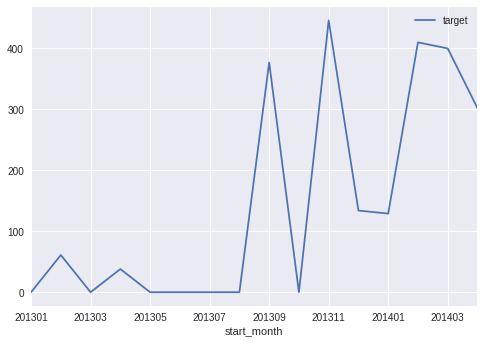

In [99]:
monthly_data.plot()

Таким образом, у нас есть иллюстрация и соображения насчет полезности нового признака, добавим его в обучающую выборку и проверим качество новой модели:

In [100]:
# добавим новый признак в разреженную матрицу
tmp = full_new_feat[['start_month']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.750835486018


Качество модели значительно ухудшилось. Мы добавили признак, который определенно казался нам полезным, но его использование только ухудшило модель. Почему так произошло?

### Лирическое отступление 2: надо ли масштабировать признаки?

Здесь мы приведем интуитивное рассуждение (строгое математическое обоснование того или иного аспекта в линейных моделях вы без труда найдете в сети). Рассмотрим признаки внимательнее: те из них, которые соответствуют количеству посещений определенного сайта за сессию, изменяются от 0 до 10. Признак `start_month` имеет совсем другую шкалу: от 201301 до 201412, это значит вклад этой переменной значительно больше остальных. Казалось бы, проблемы можно избежать, если поставить этому признаку меньший вес в линейной комбинации признаков, но в нашем случае используется логистическая регрессия с регуляризацией (по умолчанию этот параметр `C=1`), которая тем сильнее штрафует модель, чем ее веса больше.  Поэтому при использовании линейных методов с регуляризацией рекомендуется приводить признаки к одному масштабу (больше о регуляризации вы можете почитать, например, [здесь](https://habrahabr.ru/company/ods/blog/322076/)). 

Один из способов сделать это -- стандартизация: для каждого наблюдения надо отнять среднее по признаку и эту разность разделить на среднеквадратическое отклонение: 

$$ x^{*}_{i} = \dfrac{x_{i} - \mu_x}{\sigma_x}$$

Можно дать следующие практические советы:
- рекомендуется масштабировать признаки, если они находятся в существенно разных шкалах или разных единицах измерения (например, население страны указано в единицах, а ВНП страны в триллионах);
- масштабируйте признаки, если у вас нет оснований/экспертного мнения придавать больший вес каким-либо из них;
- масштабирование может быть лишним, если диапазоны некоторых ваших признаков отличаются друг от друга, но при этом находятся в одной системе единиц (например, доли людей средних лет и старше 80 среди всего населения);
- если вы хотите получить интерпретируемую модель, то постройте модель без регуляризации и масштабирования (скорее всего, ее качество окажется хуже);
- бинарные переменные (принимают только значения 0 или 1) обычно оставляют без преобразования, (но)
- если качество модели имеет решающее значение, попробуйте разные варианты и выберите тот, где качество выше.

Возвращаяся к `start_month`, масштабируем новый признак и снова обучим модель. В этот раз качество возросло:

In [101]:
# добавим новый стандартизированный признак в разреженную матрицу
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.919683066316


##### Задание 7: Добавьте в обучающую выборку признак n_unique_sites , количество уникальных сайтов в сессии, и посчитайте, как изменилось качество на отложенной выборке?

- уменьшилось, новый признак лучше не масштабировать
- не изменилось
- уменьшилось, новый признак надо масштабировать
- я в ступоре и не знаю, надо ли мастшабировать новый признак, а попробовать оба варианта и выбрать лучший не хватает смелости

*Подсказки: воспользуйтесь функцией nunique() из Pandas. Не забудьте включить в выборку start_month. Будете ли вы мастшабировать новый признак? Почему?*

In [129]:
full_new_feat['n_unique_sites'] = full_df[sites].apply(lambda row: row.replace(0, np.NaN).nunique(), axis=1)
full_new_feat.head()

,start_month,n_unique_sites
session_id,,
21669,201301,2
54843,201301,2
77292,201301,6
114021,201301,5
146670,201301,6


In [130]:
tmp_start_month = StandardScaler().fit_transform(full_new_feat[['start_month']])
tmp_unique_sites = StandardScaler().fit_transform(full_new_feat[['n_unique_sites']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             tmp_start_month[:idx_split,:],
                             tmp_unique_sites[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.916173934467


In [131]:
# Repeat without rescaling of n_unique_sites

tmp_start_month = StandardScaler().fit_transform(full_new_feat[['start_month']])
tmp_unique_sites = full_new_feat[['n_unique_sites']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             tmp_start_month[:idx_split,:],
                             tmp_unique_sites[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.91678864204


Итак, новый признак немного ухудшил качество, поэтому мы не будем его использовать. Тем не менее, не спешите выкидывать признаки, которые не сработали. Они могут пригодится для комбинации новых признаков (например, когда новый признак является отношением или произведением двух других).

##### Задание 8. Добавьте два новых признака: start_hour и morning. Посчитайте метрику, какие из признаков дали прирост?

Признак `start_hour` это час в который началась сессия (от 0 до 23), а бинарный признак `morning` равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если `start_hour равен` 11 или меньше).

Будете ли вы масштабировать новые признаки? Сделайте предположения и проверьте их на практике.

- ни один из признаков не дал прирост ;(
- `start_hour` дал прирост, а `morning` нет
- `morning` дал прирост, а `start_hour` почему-то нет
- оба признака дали прирост

*Подсказка: найдите в [справке](http://pandas.pydata.org/pandas-docs/stable/api.html) подходящие функции для работы с временными данными. Не забудьте включить признак `start_month`.*

In [145]:
# ваш код здесь
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)
full_new_feat['morning'] = (full_new_feat['start_hour'] <= 11).astype('int')
full_new_feat.head()

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301,2,8,1
54843,201301,2,8,1
77292,201301,6,8,1
114021,201301,5,8,1
146670,201301,6,8,1


In [146]:
# We will scale 'start_hour', but won't touch the binary 'morning' feature

# Try adding 'start_hour' only
tmp = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             tmp[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.957926421677


In [147]:
# Now 'morning' only
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
tmp2 = full_new_feat[['morning']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             tmp[:idx_split,:],
                             tmp2[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.948665199943


In [148]:
# Both features
tmp = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour']])
tmp2 = full_new_feat[['morning']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             tmp[:idx_split,:],
                             tmp2[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.959122172828


### 5. Подбор коэффицициента регуляризации

Итак, мы ввели признаки, которые улучшают качество нашей модели по сравнению с первым бейслайном. Можем ли мы добиться большего значения метрики? После того, как мы сформировали обучающую и тестовую выборки, почти всегда имеет смысл подобрать оптимальные гиперпараметры — характеристики модели, которые не изменяются во время обучения. Например, на 3 неделе вы проходили решающие деревья, глубина дерева это гиперпараметр, а признак, по которому происходит ветвление и его значение — нет. В используемой нами логистической регрессии веса каждого признака изменяются, и во время обучения ищутся их оптимальные значения, а коэффициент регуляризации остается постоянным. Это тот гиперпараметр, который мы сейчас будем оптимизировать.

Посчитаем качество на отложенной выборке с коэффициентом регуляризации, который по умолчанию  равен 1 (`C=1`):

In [149]:
# формируем обучающую выборку
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# зафиксируем качество с параметрами по умолчанию
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.959152062833


Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке:

In [151]:
%%time
# набор возможных значений С
Cs = np.logspace(-3, 1, 10)

scores = []
    
#for C in Cs:
#    scores.append(get_auc_lr_valid(X_train, y_train, C=C))



# установите и подключите этот модуль для отслеживания числа выполненных итераций 

from tqdm import tqdm
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 10/10 [00:25<00:00,  4.68s/it]

CPU times: user 1min 4s, sys: 36.3 s, total: 1min 40s
Wall time: 25.2 s


Построим график зависимости метрики от значения коэффициента регуляризации. Значение метрики с параметром C по умолчанию отображено горизонтальным пунктиром:

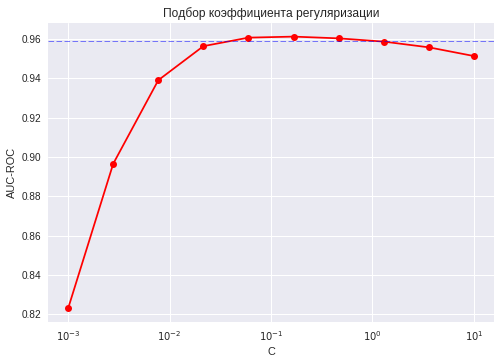

In [152]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')
# горизонтальная линия -- качество модели с коэффициентом по умолчанию
plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

##### Задание 9:  при каком коэффициенте регуляризации C модель показывает наивысшее качество?

- 0.17
- 0.46
- 1.29
- 3.14

In [156]:
# ваш код здесь
C = Cs[np.argmax(scores)]
print(C)

0.16681005372


И последнее в этой домашней работе: обучите модель с найденным оптимальным значением коэффициента регуляризации (не округляйте до двух знаков как в последнем задании). Если вы все сделали правильно и загрузите это решение, то повторите второй бейслайн — 0.93474 на паблик лидерборде:

In [157]:
# подготовим данные для обучения и теста
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# обучим модель на всей выборке с оптимальным коэффициентом регуляризации
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)

# сделаем прогноз для тестовой выборки
y_test = lr.predict_proba(X_test)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, 'baseline_2.csv')

### Заключение

В этой домашней работе вы научились пользоваться разреженными матрицами и обучать модели логистической регрессии, создали несколько признаков и отобрали лучшие из них, узнали, зачем надо масштабировать признаки и как подбирать гиперпараметры. Вот напоследок несколько идей для новых признаков: подумайте, что нового вы можете придумать по образу и подобию уже имеющихся признаков, попробуйте умножение или деление двух из них, подкрепите свои догадки графиками, постарайтесь извлечь полезную информацию из временных данных (time1 ... time10), не стесняйтесь преобразовать уже имеющийся признак (например, прологарифмировать). Мы предлагаем вам пробовать новые идеи и модели на протяжении всего курса, участвовать в соревновании – это весело!